In [1]:
import os
import glob
import math
import chardet, csv
import pandas as pd                      
import matplotlib.pyplot as plt         
import seaborn as sns                   
from scipy.stats import ( 
    kstest,
    shapiro,      # Shapiro–Wilk normaaljaotuse test
    levene,       # Levene’i test dispersioonide võrdlemiseks
    ttest_ind,    # kahe sõltumatu valimi t-test
    mannwhitneyu,  # Mann–Whitney U-test (mitteparameetriline)
    chisquare
)
from statsmodels.stats.multitest import multipletests
import pingouin as pg
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def loe_csv_automaatselt(path):

    with open(path, 'rb') as f:
        enc = chardet.detect(f.read(10000))['encoding']

    with open(path, encoding=enc) as f:
        sample = f.read(2048)
        dialect = csv.Sniffer().sniff(sample)
    return pd.read_csv(path, encoding=enc, sep=dialect.delimiter)


In [3]:
def analüüsi_fail(failitee, raw, norm):
    df = loe_csv_automaatselt(failitee)
    raw_idx, norm_idx = raw, norm

    # normaliseeritud sagedus
    mehed_norm  = df[df["gender"] == "M"].iloc[:, norm_idx].dropna()
    naised_norm = df[df["gender"] == "F"].iloc[:, norm_idx].dropna()

    # 1) KS-test
    z_m = (mehed_norm - mehed_norm.mean()) / mehed_norm.std(ddof=1)
    z_n = (naised_norm - naised_norm.mean()) / naised_norm.std(ddof=1)
    p_m, p_n = kstest(z_m, 'norm')[1], kstest(z_n, 'norm')[1]

    # 2) testi valimine
    if p_m > 0.05 and p_n > 0.05:
        eq_var = (levene(mehed_norm, naised_norm)[1] > 0.05)
        _, p_norm = ttest_ind(mehed_norm, naised_norm, equal_var=eq_var)
        test_norm = "t-test" if eq_var else "Welch"
        U = None
    else:
        U, p_norm = mannwhitneyu(mehed_norm, naised_norm, alternative='two-sided')
        test_norm = "Mann–Whitney U"

    # 3) Rank-biserial 
    if test_norm == "Mann–Whitney U":
        cles = pg.compute_effsize(mehed_norm, naised_norm, eftype='CLES')
        r_rb = 2 * cles - 1
    else:
        if U is None:
            U, _ = mannwhitneyu(mehed_norm, naised_norm, alternative='two-sided')
        n1, n2 = len(mehed_norm), len(naised_norm)
        r_rb = 1 - (2 * U) / (n1 * n2)

    # 4) salvestan absoluutsed sagedused χ²
    mehed_raw  = df[df["gender"] == "M"].iloc[:, raw_idx].dropna()
    naised_raw = df[df["gender"] == "F"].iloc[:, raw_idx].dropna()
    sum_m, sum_n = mehed_raw.sum(), naised_raw.sum()

    return {
        "failinimi": os.path.basename(failitee),
        "test_norm": test_norm,
        "p_norm":    p_norm,
        "sum_m":     sum_m,
        "sum_n":     sum_n,
        "r_rb":      r_rb,
    }

In [4]:
# kõik tulemused
csv_failid = glob.glob(os.path.join("pos_sections_csv/pos_sections_counter", "*.csv"))
tulemused = [analüüsi_fail(f, 5, 6) for f in csv_failid]
kokkuvõte_df = pd.DataFrame(tulemused)

# Holm–Bonferroni 
rej, p_holm, _, _ = multipletests(kokkuvõte_df["p_norm"], alpha=0.05, method='holm')
kokkuvõte_df["p_norm_holm"]      = p_holm
kokkuvõte_df["signif_norm_holm"] = rej

# 3) χ² + Cramer’s V kui signif_norm_holm == True
chi2_list = []
p_chi2_list = []
cramer_v_list = []
signif_chi2_list = []

for _, row in kokkuvõte_df.iterrows():
    if row["signif_norm_holm"]:
        chi2_stat, p_chi2 = chisquare([row["sum_m"], row["sum_n"]])
        N = row["sum_m"] + row["sum_n"]
        cramer_v = math.sqrt(chi2_stat / N) if N > 0 else None
        signif = (p_chi2 < 0.05)
    else:
        chi2_stat = p_chi2 = cramer_v = None
        signif = False

    chi2_list.append(chi2_stat)
    p_chi2_list.append(p_chi2)
    cramer_v_list.append(cramer_v)
    signif_chi2_list.append(signif)

kokkuvõte_df["chi2_stat"]    = chi2_list
kokkuvõte_df["p_chi2"]       = p_chi2_list
kokkuvõte_df["cramer_v"]     = cramer_v_list
kokkuvõte_df["signif_chi2"]  = signif_chi2_list

kokkuvõte_df.to_csv("tulemused_pos.csv", index=False)
print(kokkuvõte_df)


          failinimi       test_norm        p_norm  sum_m  sum_n      r_rb  \
0    kaassõnad.csv  Mann–Whitney U  1.078462e-01   5319   4364 -0.089803   
1    nimisõnad.csv  Mann–Whitney U  1.352942e-02  61116  50246 -0.129697   
2        verbid.csv           Welch  2.891384e-06  69310  58287  0.220889   
3  omadussõnad.csv  Mann–Whitney U  2.054213e-04  13729  12520 -0.198901   
4     asesõnad.csv           Welch  5.393467e-06  65097  54149  0.237611   
5      adverbid.csv  Mann–Whitney U  2.265145e-09  63572  54396 -0.317495   

    p_norm_holm  signif_norm_holm    chi2_stat         p_chi2  cramer_v  \
0  1.078462e-01             False          NaN            NaN       NaN   
1  2.705884e-02              True  1061.016325  9.815288e-233  0.097610   
2  1.445692e-05              True   952.267914  4.263394e-209  0.086389   
3  6.162638e-04              True    55.685207   8.505592e-14  0.046059   
4  2.157387e-05              True  1005.138151  1.372208e-220  0.091810   
5  1.35908

In [5]:
def plot_gender_boxplots(
    directory: str,
    norm_idx: int = 5,
    pattern: str = "*.csv"
):
   
    csv_files = glob.glob(os.path.join(directory, pattern))
    for filepath in csv_files:
  
        with open(filepath, 'r', encoding='utf-8') as f:
            sample = f.read(2048)
            try:
                dialect = csv.Sniffer().sniff(sample, delimiters=[',', ';'])
                sep = dialect.delimiter
            except csv.Error:
                sep = ','  


        df = pd.read_csv(filepath, sep=sep)
        fname = os.path.basename(filepath)


        data_m = df[df["gender"] == "M"].iloc[:, norm_idx].dropna()
        data_f = df[df["gender"] == "F"].iloc[:, norm_idx].dropna()

        # Рисуем boxplot
        fig, ax = plt.subplots()
        ax.boxplot(
            [data_m, data_f],
            tick_labels=["M", "F"],
            whis=(0, 100),
            showfliers=True
        )
        ax.set_title(f"Sageduste jaotus — {fname}")
        ax.set_ylabel("Sõnad/tund (norm.)")

           # mediaan, min, max
        for i, data in enumerate([data_m, data_f], start=1):
            q0, q1, q2, q3, q4 = np.percentile(data, [0, 25, 50, 75, 100])
            # mediaan
            ax.text(i, q2, f"{q2:.2f}", ha='center', va='bottom')
             # min
            ax.text(i - 0.1, q0, f"min:{q0:.2f}", ha='right', va='bottom', fontsize=8)
              # ьфч
            ax.text(i + 0.1, q4, f"max:{q4:.2f}", ha='left', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()



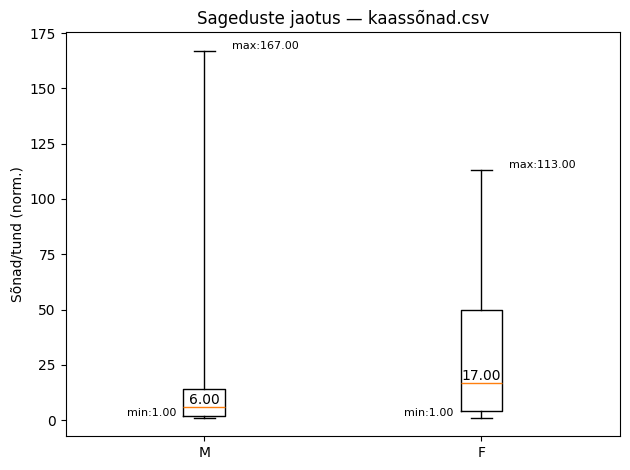

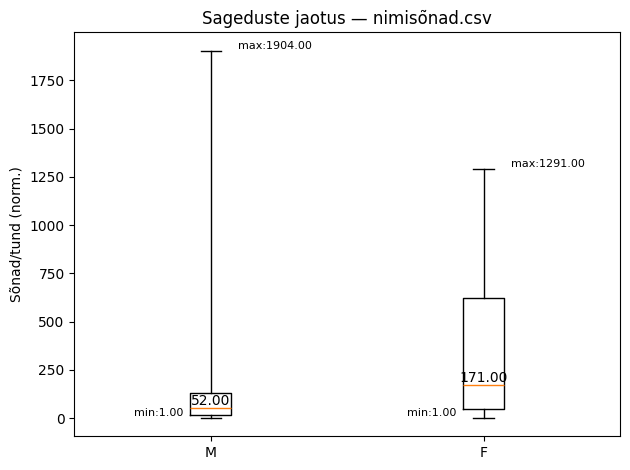

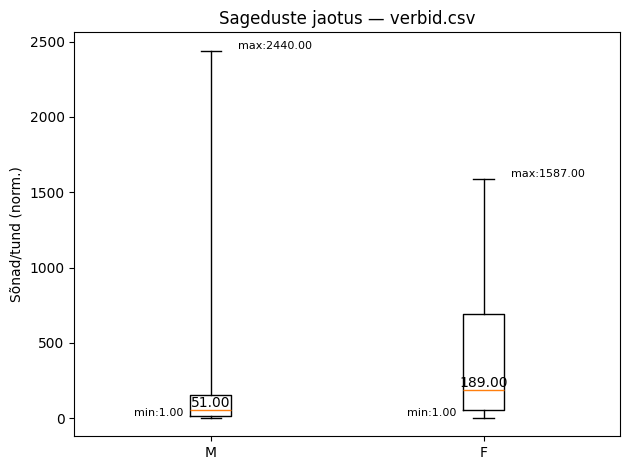

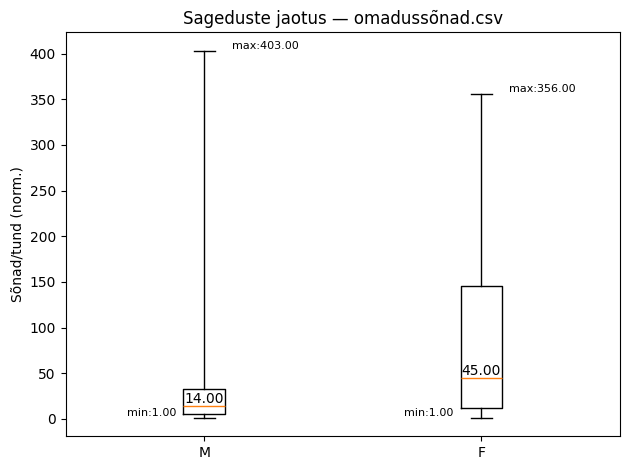

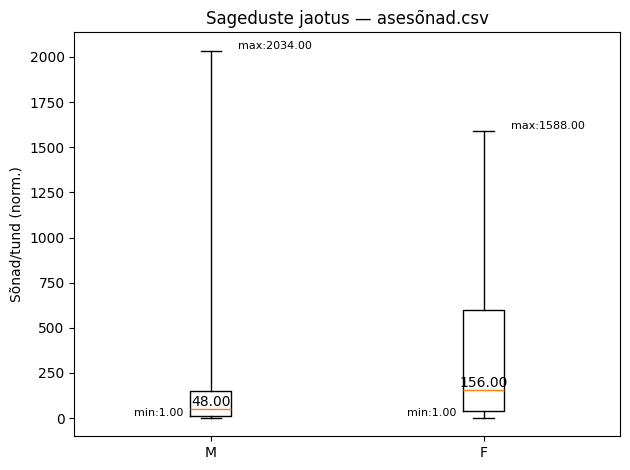

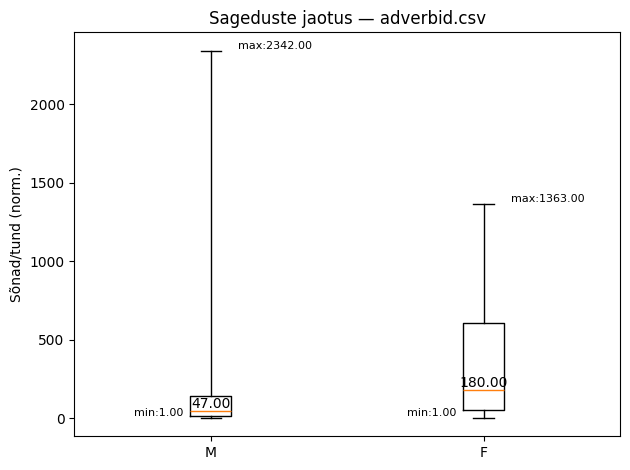

In [6]:
plot_gender_boxplots("pos_sections_csv/pos_sections_counter")

In [7]:
# kõik tulemused
csv_failid = glob.glob(os.path.join("tunnused_sections_csv", "*.csv"))
tulemused = [analüüsi_fail(f, 4, 5) for f in csv_failid]
kokkuvõte_df = pd.DataFrame(tulemused)

# Holm–Bonferroni 
rej, p_holm, _, _ = multipletests(kokkuvõte_df["p_norm"], alpha=0.05, method='holm')
kokkuvõte_df["p_norm_holm"]      = p_holm
kokkuvõte_df["signif_norm_holm"] = rej

# 3) χ² + Cramer’s V kui signif_norm_holm == True
chi2_list = []
p_chi2_list = []
cramer_v_list = []
signif_chi2_list = []

for _, row in kokkuvõte_df.iterrows():
    if row["signif_norm_holm"]:
        chi2_stat, p_chi2 = chisquare([row["sum_m"], row["sum_n"]])
        N = row["sum_m"] + row["sum_n"]
        cramer_v = math.sqrt(chi2_stat / N) if N > 0 else None
        signif = (p_chi2 < 0.05)
    else:
        chi2_stat = p_chi2 = cramer_v = None
        signif = False

    chi2_list.append(chi2_stat)
    p_chi2_list.append(p_chi2)
    cramer_v_list.append(cramer_v)
    signif_chi2_list.append(signif)

kokkuvõte_df["chi2_stat"]    = chi2_list
kokkuvõte_df["p_chi2"]       = p_chi2_list
kokkuvõte_df["cramer_v"]     = cramer_v_list
kokkuvõte_df["signif_chi2"]  = signif_chi2_list

kokkuvõte_df.to_csv("tulemused_tunnused.csv", index=False)
print(kokkuvõte_df)


                                       failinimi       test_norm  \
0        intensiivistajad_verbidega_sections.csv  Mann–Whitney U   
1               verbid_partiklidena_sections.csv  Mann–Whitney U   
2      intensiivistajad_adverbidega_sections.csv  Mann–Whitney U   
3                           eitused_sections.csv  Mann–Whitney U   
4                         tingiv_per_section.csv  Mann–Whitney U   
5   intensiivistajad_omadussonadega_sections.csv  Mann–Whitney U   
6             esimese_ja_teise_isik_sections.csv  Mann–Whitney U   
7                            kaskiv_sections.csv  Mann–Whitney U   
8                   umbisikuline_per_section.csv  Mann–Whitney U   
9                         partikkel_sections.csv  Mann–Whitney U   
10                      kp_markerid_sections.csv  Mann–Whitney U   

          p_norm  sum_m  sum_n      r_rb   p_norm_holm  signif_norm_holm  \
0   1.750852e-01   1432   1366 -0.083658  5.252556e-01             False   
1   1.579274e-13    666    160 

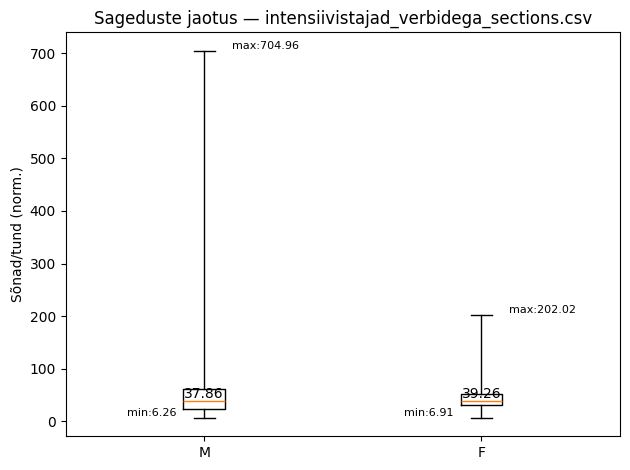

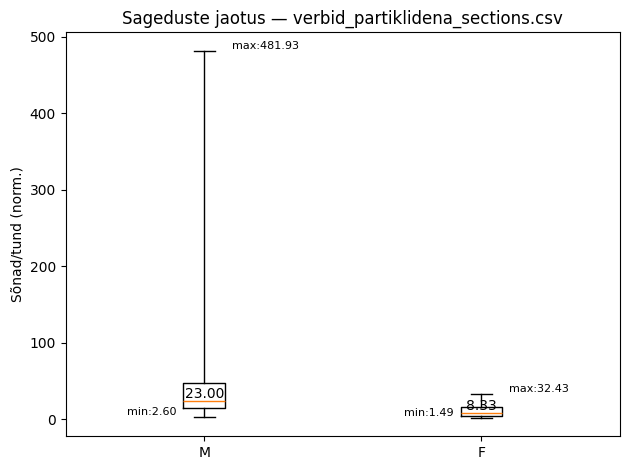

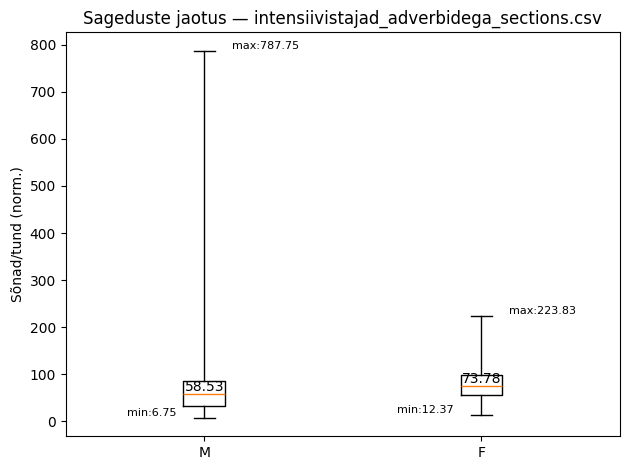

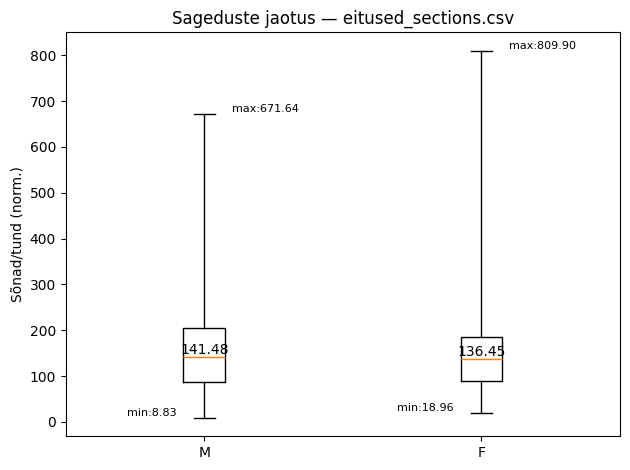

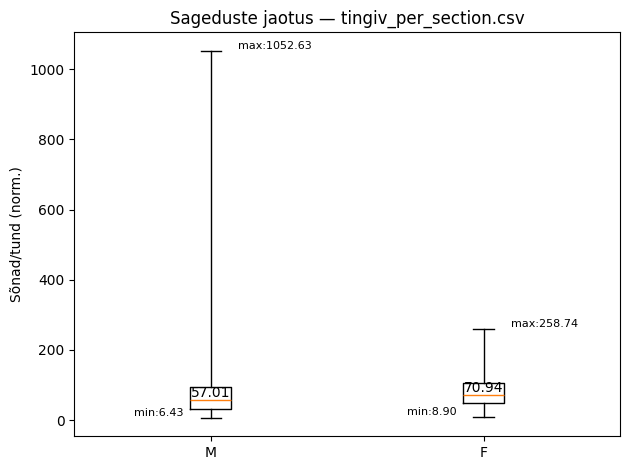

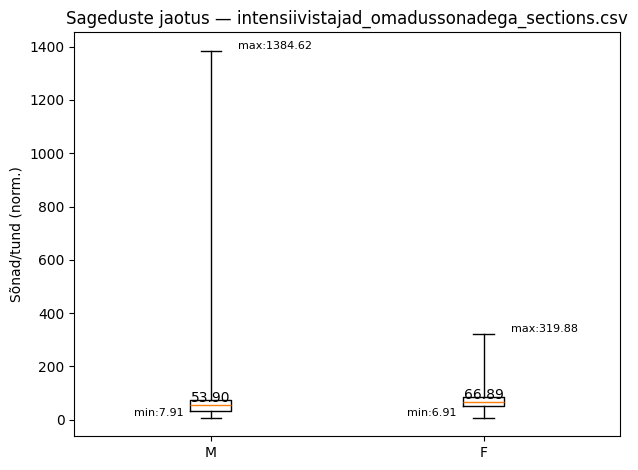

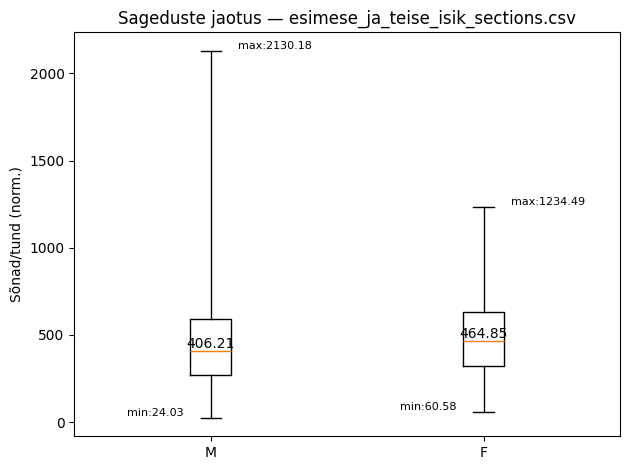

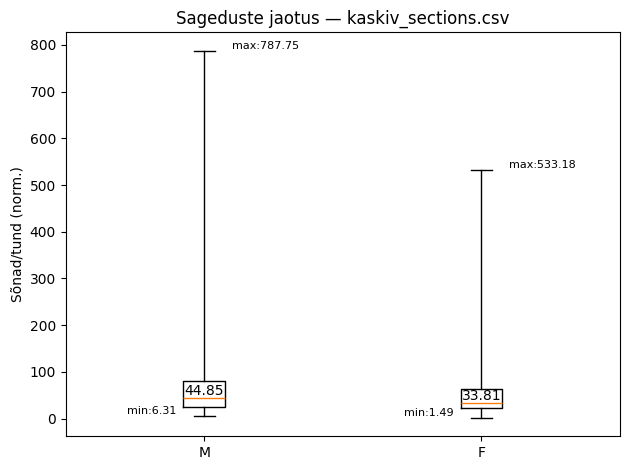

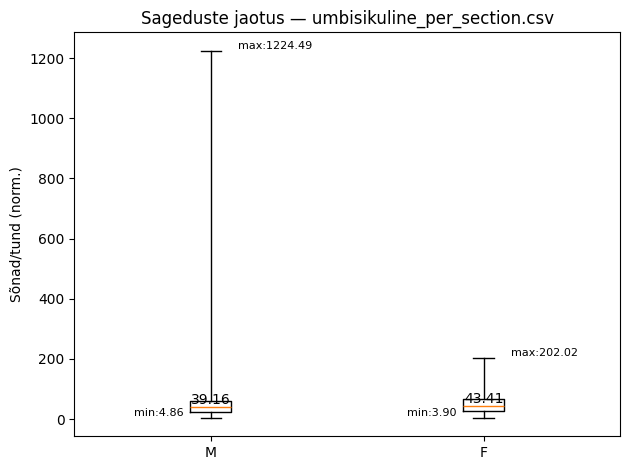

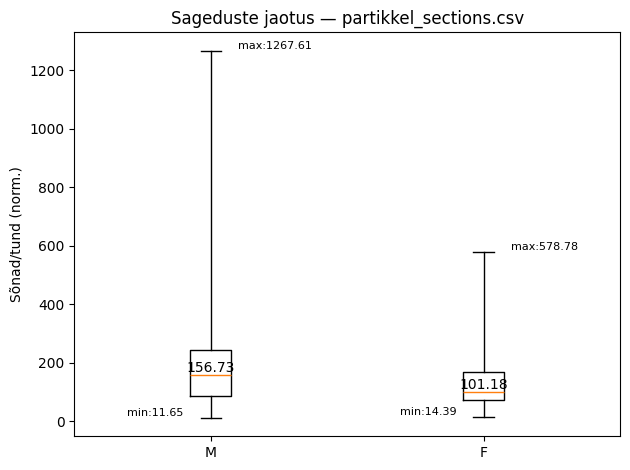

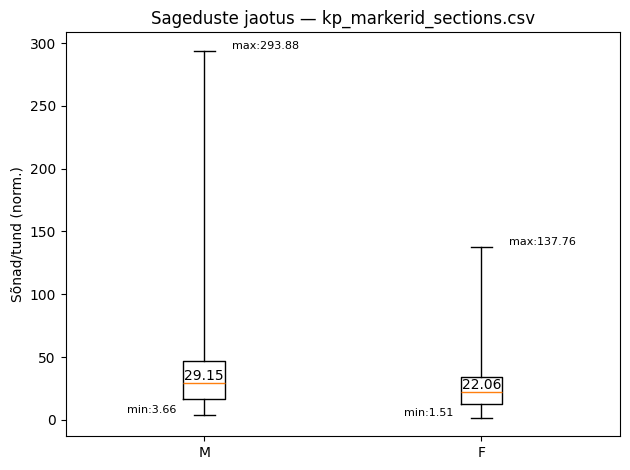

In [8]:
plot_gender_boxplots("tunnused_sections_csv")

In [9]:
# kõik tulemused
csv_failid = glob.glob(os.path.join("sections_partikkel", "*.csv"))
tulemused = [analüüsi_fail(f, 4, 5) for f in csv_failid]
kokkuvõte_df = pd.DataFrame(tulemused)

# Holm–Bonferroni 
rej, p_holm, _, _ = multipletests(kokkuvõte_df["p_norm"], alpha=0.05, method='holm')
kokkuvõte_df["p_norm_holm"]      = p_holm
kokkuvõte_df["signif_norm_holm"] = rej

# 3) χ² + Cramer’s V kui signif_norm_holm == True
chi2_list = []
p_chi2_list = []
cramer_v_list = []
signif_chi2_list = []

for _, row in kokkuvõte_df.iterrows():
    if row["signif_norm_holm"]:
        chi2_stat, p_chi2 = chisquare([row["sum_m"], row["sum_n"]])
        N = row["sum_m"] + row["sum_n"]
        cramer_v = math.sqrt(chi2_stat / N) if N > 0 else None
        signif = (p_chi2 < 0.05)
    else:
        chi2_stat = p_chi2 = cramer_v = None
        signif = False

    chi2_list.append(chi2_stat)
    p_chi2_list.append(p_chi2)
    cramer_v_list.append(cramer_v)
    signif_chi2_list.append(signif)

kokkuvõte_df["chi2_stat"]    = chi2_list
kokkuvõte_df["p_chi2"]       = p_chi2_list
kokkuvõte_df["cramer_v"]     = cramer_v_list
kokkuvõte_df["signif_chi2"]  = signif_chi2_list

kokkuvõte_df.to_csv("tulemused_partiklid.csv", index=False)
print(kokkuvõte_df)


            failinimi       test_norm        p_norm  sum_m  sum_n      r_rb  \
0     no_sections.csv  Mann–Whitney U  1.183848e-09    474    195  0.524974   
1     oh_sections.csv  Mann–Whitney U  6.040535e-02     39     19  0.364764   
2    vot_sections.csv  Mann–Whitney U  1.132351e-02     74     59  0.356322   
3   nagu_sections.csv  Mann–Whitney U  2.785576e-07   7225   3732  0.298687   
4   okei_sections.csv  Mann–Whitney U  3.118401e-05    225    124  0.435383   
5    jah_sections.csv  Mann–Whitney U  2.830364e-05     67     44  0.544444   
6  aitäh_sections.csv  Mann–Whitney U  7.468456e-03     47     74  0.356463   
7    noh_sections.csv  Mann–Whitney U  5.873158e-05    345    230  0.352102   

    p_norm_holm  signif_norm_holm    chi2_stat         p_chi2  cramer_v  \
0  9.470784e-09              True   116.354260   3.975455e-27  0.417040   
1  6.040535e-02             False          NaN            NaN       NaN   
2  2.264702e-02              True     1.691729   1.933732e-01  

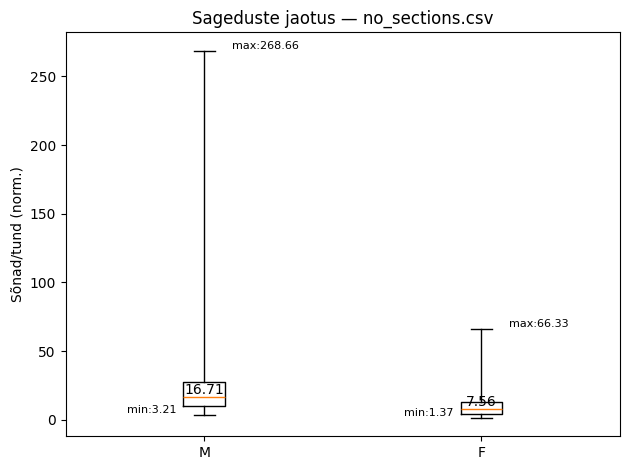

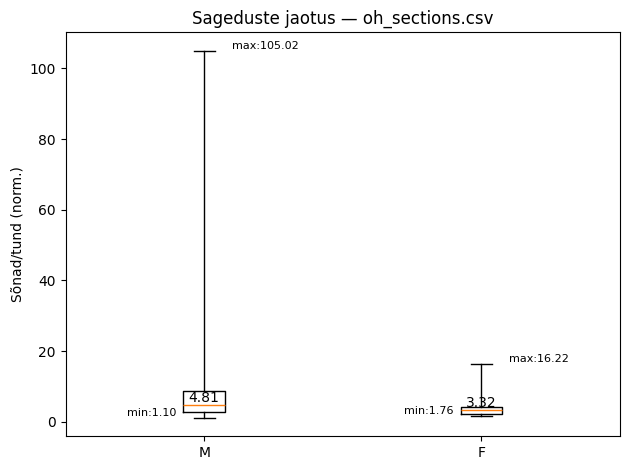

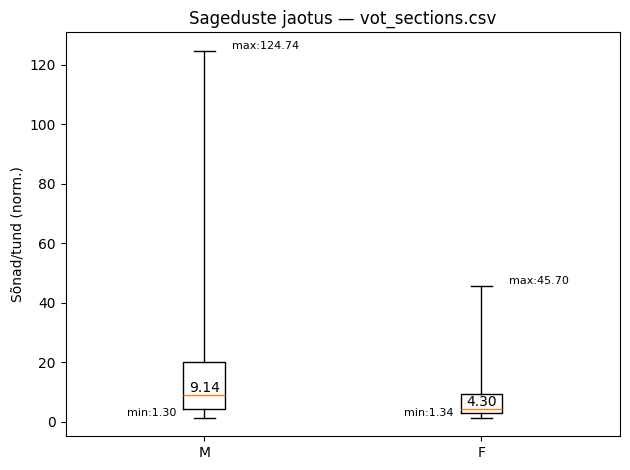

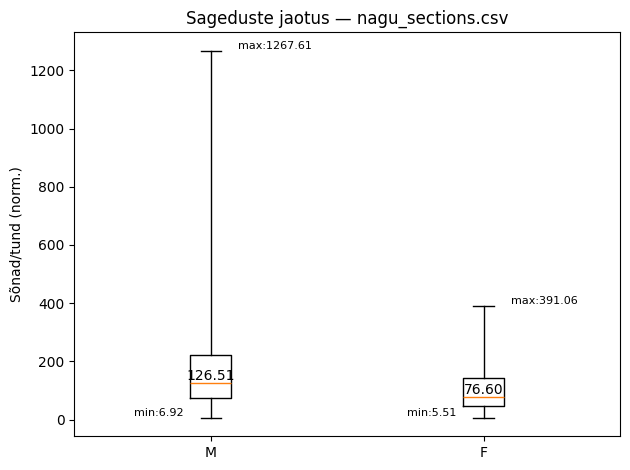

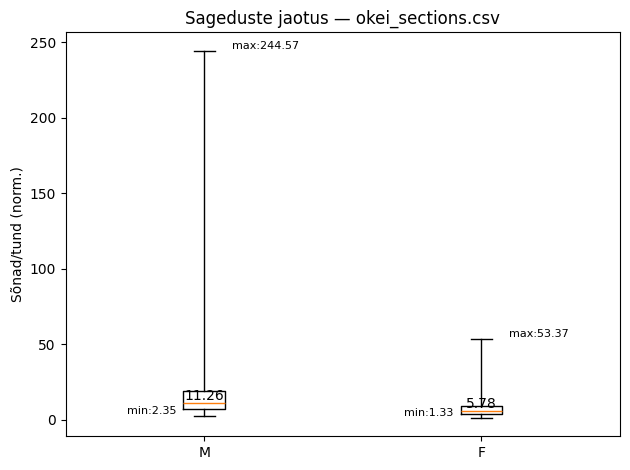

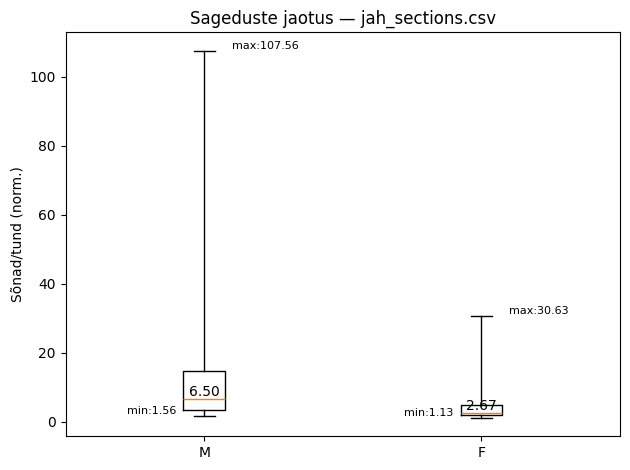

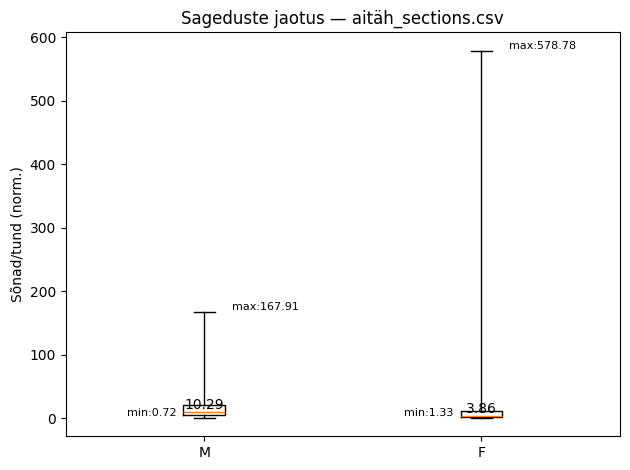

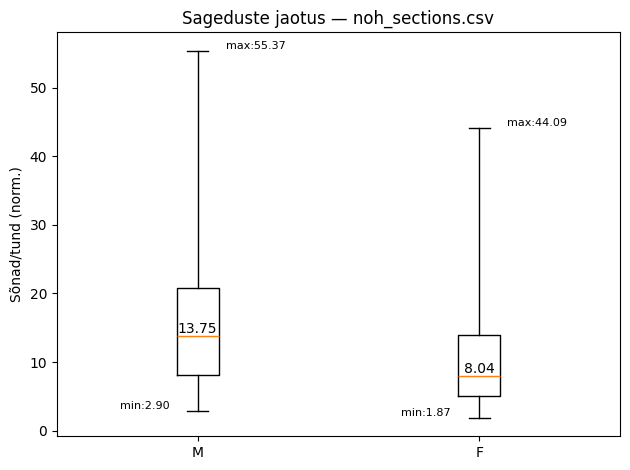

In [10]:
plot_gender_boxplots("sections_partikkel")

In [11]:
# kõik tulemused
csv_failid = glob.glob(os.path.join("sections_kp_markerid", "*.csv"))
tulemused = [analüüsi_fail(f, 4, 5) for f in csv_failid]
kokkuvõte_df = pd.DataFrame(tulemused)

# Holm–Bonferroni 
rej, p_holm, _, _ = multipletests(kokkuvõte_df["p_norm"], alpha=0.05, method='holm')
kokkuvõte_df["p_norm_holm"]      = p_holm
kokkuvõte_df["signif_norm_holm"] = rej

# 3) χ² + Cramer’s V kui signif_norm_holm == True
chi2_list = []
p_chi2_list = []
cramer_v_list = []
signif_chi2_list = []

for _, row in kokkuvõte_df.iterrows():
    if row["signif_norm_holm"]:
        chi2_stat, p_chi2 = chisquare([row["sum_m"], row["sum_n"]])
        N = row["sum_m"] + row["sum_n"]
        cramer_v = math.sqrt(chi2_stat / N) if N > 0 else None
        signif = (p_chi2 < 0.05)
    else:
        chi2_stat = p_chi2 = cramer_v = None
        signif = False

    chi2_list.append(chi2_stat)
    p_chi2_list.append(p_chi2)
    cramer_v_list.append(cramer_v)
    signif_chi2_list.append(signif)

kokkuvõte_df["chi2_stat"]    = chi2_list
kokkuvõte_df["p_chi2"]       = p_chi2_list
kokkuvõte_df["cramer_v"]     = cramer_v_list
kokkuvõte_df["signif_chi2"]  = signif_chi2_list

kokkuvõte_df.to_csv("tulemused_kp.csv", index=False)
print(kokkuvõte_df)


             failinimi       test_norm    p_norm  sum_m  sum_n      r_rb  \
0  loodan_sections.csv  Mann–Whitney U  0.024997     56     41  0.317073   
1  tundub_sections.csv  Mann–Whitney U  0.015176    166    125  0.233964   
2   arvan_sections.csv  Mann–Whitney U  0.000003    642    362  0.355556   
3    usun_sections.csv  Mann–Whitney U  0.105674     71     71  0.197170   

   p_norm_holm  signif_norm_holm  chi2_stat        p_chi2  cramer_v  \
0     0.049994              True   2.319588  1.277539e-01  0.154639   
1     0.045529              True   5.776632  1.624063e-02  0.140893   
2     0.000011              True  78.087649  9.856832e-19  0.278884   
3     0.105674             False        NaN           NaN       NaN   

   signif_chi2  
0        False  
1         True  
2         True  
3        False  


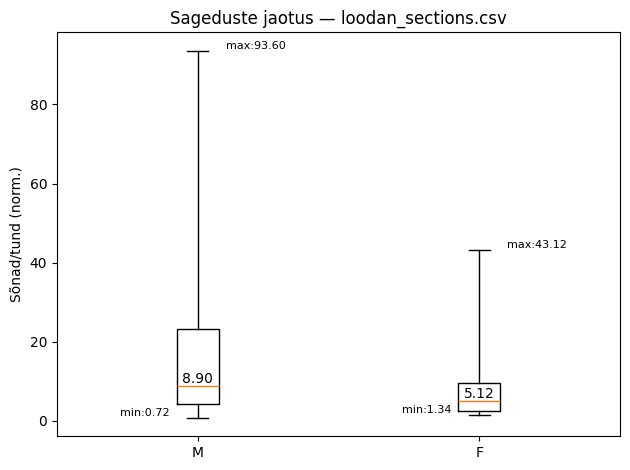

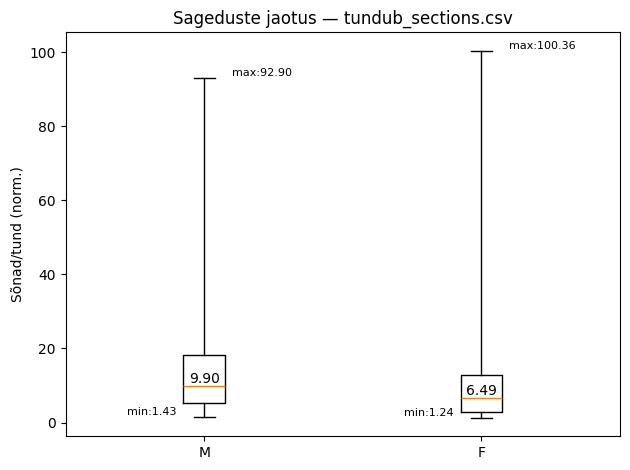

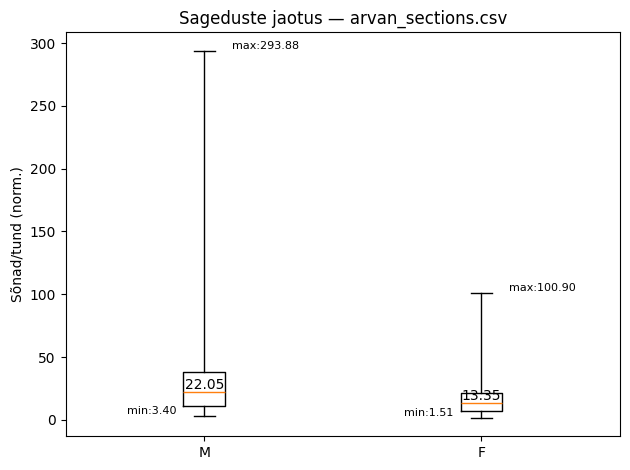

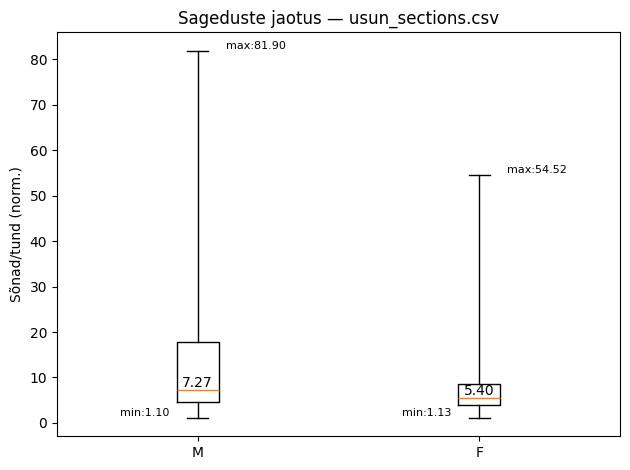

In [12]:
plot_gender_boxplots("sections_kp_markerid")

In [13]:
# kõik tulemused
csv_failid = glob.glob(os.path.join("sections_intensiivistajad_omadussonadega", "*.csv"))
tulemused = [analüüsi_fail(f, 4, 5) for f in csv_failid]
kokkuvõte_df = pd.DataFrame(tulemused)

# Holm–Bonferroni 
rej, p_holm, _, _ = multipletests(kokkuvõte_df["p_norm"], alpha=0.05, method='holm')
kokkuvõte_df["p_norm_holm"]      = p_holm
kokkuvõte_df["signif_norm_holm"] = rej

# 3) χ² + Cramer’s V kui signif_norm_holm == True
chi2_list = []
p_chi2_list = []
cramer_v_list = []
signif_chi2_list = []

for _, row in kokkuvõte_df.iterrows():
    if row["signif_norm_holm"]:
        chi2_stat, p_chi2 = chisquare([row["sum_m"], row["sum_n"]])
        N = row["sum_m"] + row["sum_n"]
        cramer_v = math.sqrt(chi2_stat / N) if N > 0 else None
        signif = (p_chi2 < 0.05)
    else:
        chi2_stat = p_chi2 = cramer_v = None
        signif = False

    chi2_list.append(chi2_stat)
    p_chi2_list.append(p_chi2)
    cramer_v_list.append(cramer_v)
    signif_chi2_list.append(signif)

kokkuvõte_df["chi2_stat"]    = chi2_list
kokkuvõte_df["p_chi2"]       = p_chi2_list
kokkuvõte_df["cramer_v"]     = cramer_v_list
kokkuvõte_df["signif_chi2"]  = signif_chi2_list

kokkuvõte_df.to_csv("tulemused_intensiivistajad_omadussonadega.csv", index=False)
print(kokkuvõte_df)


               failinimi       test_norm    p_norm  sum_m  sum_n      r_rb  \
0       nii_sections.csv  Mann–Whitney U  0.452607    324    357  0.058391   
1     üldse_sections.csv  Mann–Whitney U  0.303154     36     31  0.180451   
2       kui_sections.csv  Mann–Whitney U  0.001099    122    132  0.308189   
3     palju_sections.csv  Mann–Whitney U  0.547353     53     90  0.069732   
4    natuke_sections.csv           Welch  0.005594     31     20 -0.482353   
5     päris_sections.csv  Mann–Whitney U  0.016691    175    110  0.229973   
6   täiesti_sections.csv  Mann–Whitney U  0.165897     67     98  0.160757   
7      üsna_sections.csv           Welch  0.011132     51     32 -0.291667   
8     hästi_sections.csv  Mann–Whitney U  0.662143    164    289 -0.043478   
9      suht_sections.csv          t-test  0.718884     53      4 -0.010753   
10    liiga_sections.csv          t-test  0.052596     39     32 -0.333333   
11     väga_sections.csv  Mann–Whitney U  0.504258    828    936

In [14]:
# kõik tulemused
csv_failid = glob.glob(os.path.join("sections_intensiivistajad_adverbidega", "*.csv"))
tulemused = [analüüsi_fail(f, 4, 5) for f in csv_failid]
kokkuvõte_df = pd.DataFrame(tulemused)

# Holm–Bonferroni 
rej, p_holm, _, _ = multipletests(kokkuvõte_df["p_norm"], alpha=0.05, method='holm')
kokkuvõte_df["p_norm_holm"]      = p_holm
kokkuvõte_df["signif_norm_holm"] = rej

# 3) χ² + Cramer’s V kui signif_norm_holm == True
chi2_list = []
p_chi2_list = []
cramer_v_list = []
signif_chi2_list = []

for _, row in kokkuvõte_df.iterrows():
    if row["signif_norm_holm"]:
        chi2_stat, p_chi2 = chisquare([row["sum_m"], row["sum_n"]])
        N = row["sum_m"] + row["sum_n"]
        cramer_v = math.sqrt(chi2_stat / N) if N > 0 else None
        signif = (p_chi2 < 0.05)
    else:
        chi2_stat = p_chi2 = cramer_v = None
        signif = False

    chi2_list.append(chi2_stat)
    p_chi2_list.append(p_chi2)
    cramer_v_list.append(cramer_v)
    signif_chi2_list.append(signif)

kokkuvõte_df["chi2_stat"]    = chi2_list
kokkuvõte_df["p_chi2"]       = p_chi2_list
kokkuvõte_df["cramer_v"]     = cramer_v_list
kokkuvõte_df["signif_chi2"]  = signif_chi2_list

kokkuvõte_df.to_csv("tulemused_intensiivistajad_adverbidega.csv", index=False)
print(kokkuvõte_df)

                failinimi       test_norm    p_norm  sum_m  sum_n      r_rb  \
0        nii_sections.csv  Mann–Whitney U  0.039784    498    483  0.150570   
1      üldse_sections.csv  Mann–Whitney U  0.202646     60     71  0.155556   
2     tõesti_sections.csv  Mann–Whitney U  0.367137     44     74  0.120321   
3        kui_sections.csv  Mann–Whitney U  0.018023    504    458  0.171396   
4      palju_sections.csv  Mann–Whitney U  0.268091    117    131  0.114257   
5     natuke_sections.csv  Mann–Whitney U  0.000373     94     67  0.418719   
6      päris_sections.csv  Mann–Whitney U  0.002074    130    134  0.302564   
7    täiesti_sections.csv  Mann–Whitney U  0.238960     63     55  0.156757   
8       üsna_sections.csv  Mann–Whitney U  0.526881     32     22  0.129870   
9      hästi_sections.csv  Mann–Whitney U  0.063487    157    221  0.181525   
10  natukene_sections.csv  Mann–Whitney U  0.122010     47     78  0.200483   
11     liiga_sections.csv  Mann–Whitney U  0.003284 

Siin edasi minu esimesed katsed:

7     135.26
39     66.33
40    233.62
49    142.63
50    242.24
Name: eitused_per_hour, dtype: float64


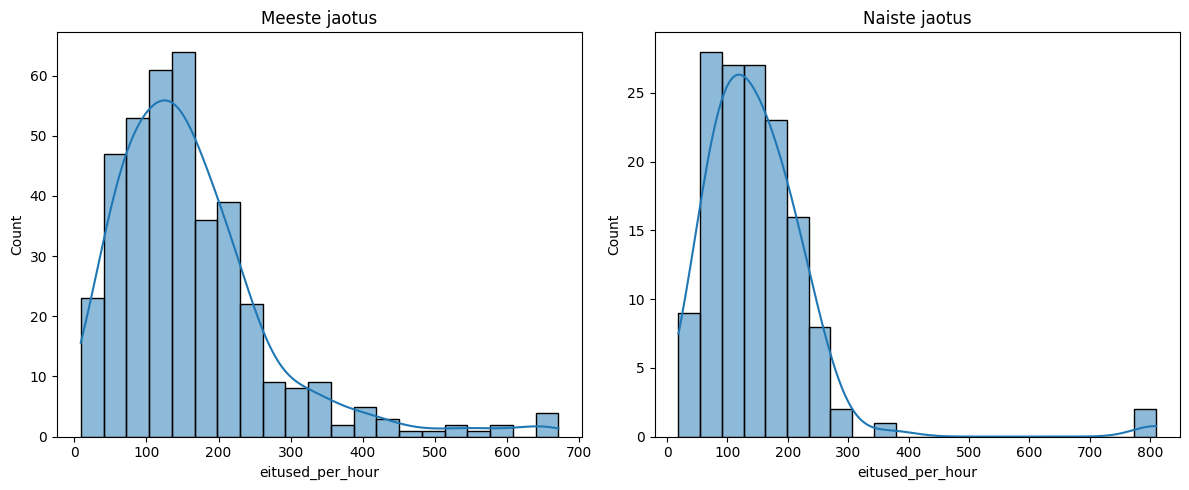

Shapiro (M): W=0.852, p=9.295e-19
Shapiro (F): W=0.679, p=2.848e-16
Mann–Whitney U: U=29279.000, p=4.294e-01


In [17]:
import pandas as pd                      
import matplotlib.pyplot as plt         
import seaborn as sns                   
from scipy.stats import ( 
    kstest,
    shapiro,      # Shapiro–Wilk normaaljaotuse test
    levene,       # Levene’i test dispersioonide võrdlemiseks
    ttest_ind,    # kahe sõltumatu valimi t-test
    mannwhitneyu  # Mann–Whitney U-test (mitteparameetriline)
)


df = pd.read_csv("data/eitused_per_section.csv")  

# Vali eraldi meeste ja naiste andmed
men   = df[df["gender"] == "M"]["eitused_per_hour"]
women = df[df["gender"] == "F"]["eitused_per_hour"]

print(women.head())
# Visualiseerimine

#  Jaotuse histogrammid koos KDE-ga
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)                     
sns.histplot(men, kde=True)              
plt.title("Meeste jaotus")              

plt.subplot(1, 2, 2)                     
sns.histplot(women, kde=True)            
plt.title("Naiste jaotus")               

plt.tight_layout()                       
plt.show()                               

# Normaaljaotuse test (Shapiro–Wilk)
W_m, p_m = shapiro(men)   # meeste W-statistik ja p-väärtus
W_f, p_f = shapiro(women) # naiste W-statistik ja p-väärtus
print(f"Shapiro (M): W={W_m:.3f}, p={p_m:.3e}")
print(f"Shapiro (F): W={W_f:.3f}, p={p_f:.3e}")

# Statistilise testi valik
if p_m > 0.05 and p_f > 0.05:
    # Kui mõlema grupi jaotus on normaalne – kontrollime dispersioonide võrdsust
    stat_lev, p_lev = levene(men, women)
    equal_var = (p_lev > 0.05)   # True, kui dispersioonid on võrdsed
    print(f"Levene: stat={stat_lev:.3f}, p={p_lev:.3f} → equal_var={equal_var}")

    # T-test (Student või Welch)
    t_stat, p_t = ttest_ind(men, women, equal_var=equal_var)
    print(f"t-test (equal_var={equal_var}): t={t_stat:.3f}, p={p_t:.3e}")

    # Mõjusuuruse arvutamine (Cohen’s d)
    import numpy as np
    diff = men.mean() - women.mean()
    pooled_sd = np.sqrt((men.std(ddof=1)**2 + women.std(ddof=1)**2) / 2)
    cohens_d = diff / pooled_sd
    print(f"Cohen’s d = {cohens_d:.3f}")
else:
    # Kui vähemalt ühe grupi jaotus ei ole normaalne – Mann–Whitney U-test
    U, p_u = mannwhitneyu(men, women)
    print(f"Mann–Whitney U: U={U:.3f}, p={p_u:.3e}")


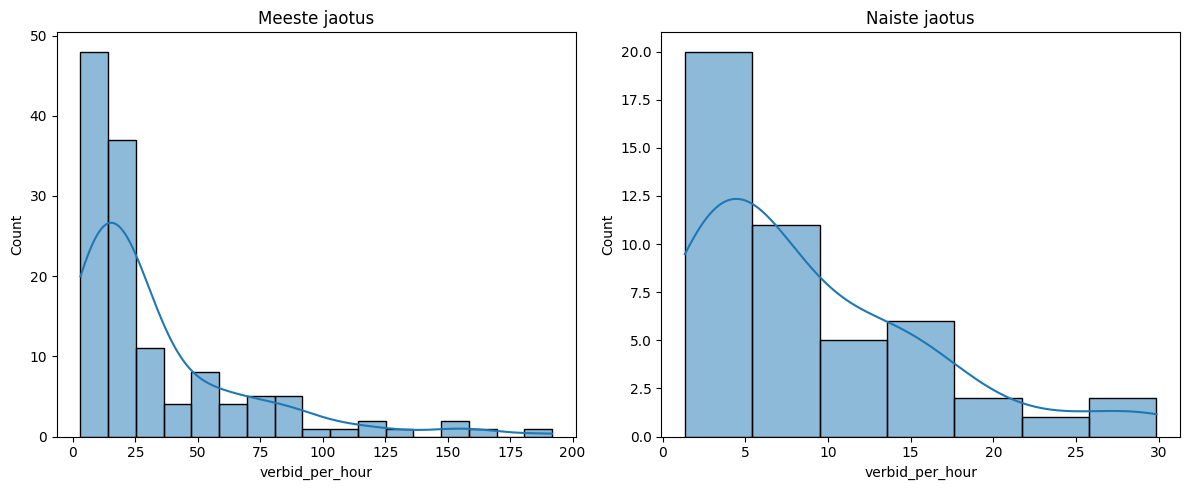

Shapiro (M): W=0.744, p=7.841e-14
Shapiro (F): W=0.857, p=4.047e-05
Mann–Whitney U: U=5036.500, p=1.052e-10


In [2]:
import pandas as pd                      
import matplotlib.pyplot as plt         
import seaborn as sns                   
from scipy.stats import (                
    shapiro,      # Shapiro–Wilk normaaljaotuse test
    levene,       # Levene’i test dispersioonide võrdlemiseks
    ttest_ind,    # kahe sõltumatu valimi t-test
    mannwhitneyu  # Mann–Whitney U-test (mitteparameetriline)
)


df = pd.read_csv("data/vaata_oota_section.csv")  

# Vali eraldi meeste ja naiste andmed
men   = df[df["gender"] == "M"]["verbid_per_hour"]
women = df[df["gender"] == "F"]["verbid_per_hour"]

# Visualiseerimine

#  Jaotuse histogrammid koos KDE-ga
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)                     
sns.histplot(men, kde=True)              
plt.title("Meeste jaotus")              

plt.subplot(1, 2, 2)                     
sns.histplot(women, kde=True)            
plt.title("Naiste jaotus")               

plt.tight_layout()                       
plt.show()                               

# Normaaljaotuse test (Shapiro–Wilk)
W_m, p_m = shapiro(men)   # meeste W-statistik ja p-väärtus
W_f, p_f = shapiro(women) # naiste W-statistik ja p-väärtus
print(f"Shapiro (M): W={W_m:.3f}, p={p_m:.3e}")
print(f"Shapiro (F): W={W_f:.3f}, p={p_f:.3e}")

# Statistilise testi valik
if p_m > 0.05 and p_f > 0.05:
    # Kui mõlema grupi jaotus on normaalne – kontrollime dispersioonide võrdsust
    stat_lev, p_lev = levene(men, women)
    equal_var = (p_lev > 0.05)   # True, kui dispersioonid on võrdsed
    print(f"Levene: stat={stat_lev:.3f}, p={p_lev:.3f} → equal_var={equal_var}")

    # T-test (Student või Welch)
    t_stat, p_t = ttest_ind(men, women, equal_var=equal_var)
    print(f"t-test (equal_var={equal_var}): t={t_stat:.3f}, p={p_t:.3e}")

    # Mõjusuuruse arvutamine (Cohen’s d)
    import numpy as np
    diff = men.mean() - women.mean()
    pooled_sd = np.sqrt((men.std(ddof=1)**2 + women.std(ddof=1)**2) / 2)
    cohens_d = diff / pooled_sd
    print(f"Cohen’s d = {cohens_d:.3f}")
else:
    # Kui vähemalt ühe grupi jaotus ei ole normaalne – Mann–Whitney U-test
    U, p_u = mannwhitneyu(men, women)
    print(f"Mann–Whitney U: U={U:.3f}, p={p_u:.3e}")


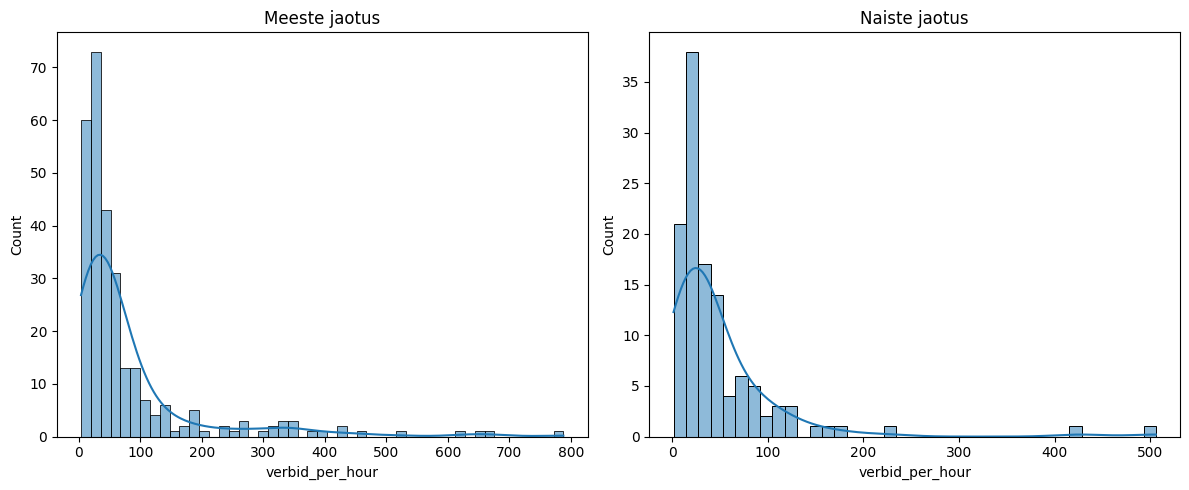

Shapiro (M): W=0.581, p=1.220e-25
Shapiro (F): W=0.543, p=1.355e-17
Mann–Whitney U: U=20124.500, p=2.492e-03


In [3]:
df = pd.read_csv("data/kaskiv_section.csv")  

# Vali eraldi meeste ja naiste andmed
men   = df[df["gender"] == "M"]["verbid_per_hour"]
women = df[df["gender"] == "F"]["verbid_per_hour"]

# Visualiseerimine

#  Jaotuse histogrammid koos KDE-ga
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)                     
sns.histplot(men, kde=True)              
plt.title("Meeste jaotus")              

plt.subplot(1, 2, 2)                     
sns.histplot(women, kde=True)            
plt.title("Naiste jaotus")               

plt.tight_layout()                       
plt.show()                               

# Normaaljaotuse test (Shapiro–Wilk)
W_m, p_m = shapiro(men)   # meeste W-statistik ja p-väärtus
W_f, p_f = shapiro(women) # naiste W-statistik ja p-väärtus
print(f"Shapiro (M): W={W_m:.3f}, p={p_m:.3e}")
print(f"Shapiro (F): W={W_f:.3f}, p={p_f:.3e}")

# Statistilise testi valik
if p_m > 0.05 and p_f > 0.05:
    # Kui mõlema grupi jaotus on normaalne – kontrollime dispersioonide võrdsust
    stat_lev, p_lev = levene(men, women)
    equal_var = (p_lev > 0.05)   # True, kui dispersioonid on võrdsed
    print(f"Levene: stat={stat_lev:.3f}, p={p_lev:.3f} → equal_var={equal_var}")

    # T-test (Student või Welch)
    t_stat, p_t = ttest_ind(men, women, equal_var=equal_var)
    print(f"t-test (equal_var={equal_var}): t={t_stat:.3f}, p={p_t:.3e}")

    # Mõjusuuruse arvutamine (Cohen’s d)
    import numpy as np
    diff = men.mean() - women.mean()
    pooled_sd = np.sqrt((men.std(ddof=1)**2 + women.std(ddof=1)**2) / 2)
    cohens_d = diff / pooled_sd
    print(f"Cohen’s d = {cohens_d:.3f}")
else:
    # Kui vähemalt ühe grupi jaotus ei ole normaalne – Mann–Whitney U-test
    U, p_u = mannwhitneyu(men, women)
    print(f"Mann–Whitney U: U={U:.3f}, p={p_u:.3e}")


                                          episode_id  section_index gender  \
0  20190101_mehed_ei_nuta_suur_uusaastasaade_abso...              1      M   
1  20190101_mehed_ei_nuta_suur_uusaastasaade_abso...              2      M   
2  20190101_mehed_ei_nuta_suur_uusaastasaade_abso...              3      M   
3  20190101_mehed_ei_nuta_suur_uusaastasaade_abso...              4      M   
4    20190102_58_saade__ajurveeda_edendaja_kaja_keil              0      F   

   total_verbs    minutes  partikkel_per_hour  
0           12   6.895333              104.42  
1          182  38.380167              284.52  
2            9   1.458667              370.20  
3          340  70.770667              288.26  
4           96  43.915667              131.16  


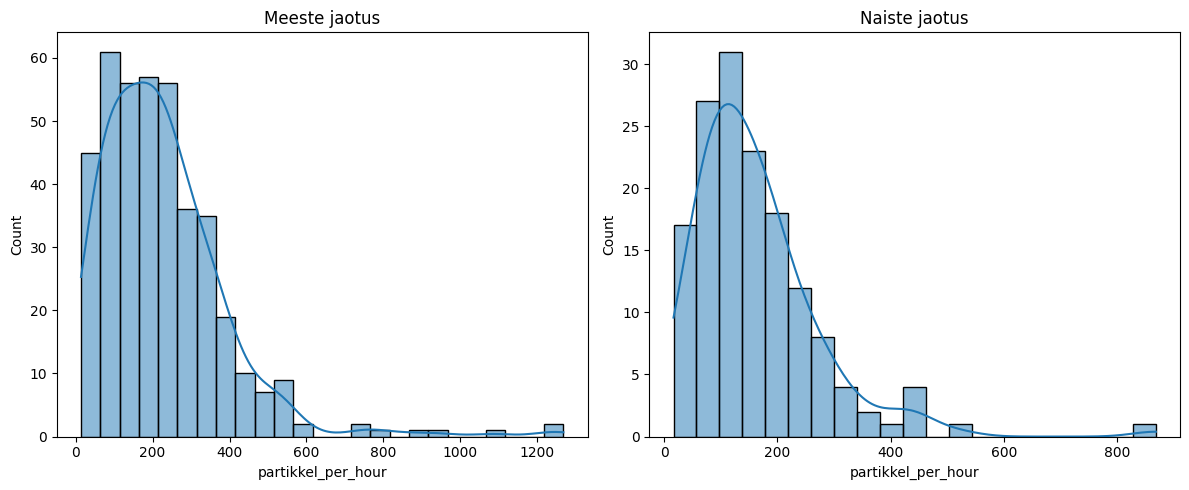

Shapiro (M): W=0.836, p=6.123e-20
Shapiro (F): W=0.827, p=5.615e-12
Mann–Whitney U: U=37328.500, p=6.796e-06


In [4]:

df = pd.read_csv("data/partiklid_section.csv", sep=';')  
print(df.head())
# Vali eraldi meeste ja naiste andmed
men   = df[df["gender"] == "M"]["partikkel_per_hour"]
women = df[df["gender"] == "F"]["partikkel_per_hour"]

# Visualiseerimine

#  Jaotuse histogrammid koos KDE-ga
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)                     
sns.histplot(men, kde=True)              
plt.title("Meeste jaotus")              

plt.subplot(1, 2, 2)                     
sns.histplot(women, kde=True)            
plt.title("Naiste jaotus")               

plt.tight_layout()                       
plt.show()                               

# Normaaljaotuse test (Shapiro–Wilk)
W_m, p_m = shapiro(men)   # meeste W-statistik ja p-väärtus
W_f, p_f = shapiro(women) # naiste W-statistik ja p-väärtus
print(f"Shapiro (M): W={W_m:.3f}, p={p_m:.3e}")
print(f"Shapiro (F): W={W_f:.3f}, p={p_f:.3e}")

# Statistilise testi valik
if p_m > 0.05 and p_f > 0.05:
    # Kui mõlema grupi jaotus on normaalne – kontrollime dispersioonide võrdsust
    stat_lev, p_lev = levene(men, women)
    equal_var = (p_lev > 0.05)   # True, kui dispersioonid on võrdsed
    print(f"Levene: stat={stat_lev:.3f}, p={p_lev:.3f} → equal_var={equal_var}")

    # T-test (Student või Welch)
    t_stat, p_t = ttest_ind(men, women, equal_var=equal_var)
    print(f"t-test (equal_var={equal_var}): t={t_stat:.3f}, p={p_t:.3e}")

    # Mõjusuuruse arvutamine (Cohen’s d)
    import numpy as np
    diff = men.mean() - women.mean()
    pooled_sd = np.sqrt((men.std(ddof=1)**2 + women.std(ddof=1)**2) / 2)
    cohens_d = diff / pooled_sd
    print(f"Cohen’s d = {cohens_d:.3f}")
else:
    # Kui vähemalt ühe grupi jaotus ei ole normaalne – Mann–Whitney U-test
    U, p_u = mannwhitneyu(men, women)
    print(f"Mann–Whitney U: U={U:.3f}, p={p_u:.3e}")


                                          episode_id  section_index gender  \
0  20190101_mehed_ei_nuta_suur_uusaastasaade_abso...              1      M   
1  20190101_mehed_ei_nuta_suur_uusaastasaade_abso...              2      M   
2  20190101_mehed_ei_nuta_suur_uusaastasaade_abso...              3      M   
3  20190101_mehed_ei_nuta_suur_uusaastasaade_abso...              4      M   
4    20190102_58_saade__ajurveeda_edendaja_kaja_keil              0      F   

   total_intensifiers    minutes  intensifiers_per_hour  
0                   4   6.895333                  34.81  
1                  49  38.380167                  76.60  
2                   3   1.458667                 123.40  
3                  63  70.770667                  53.41  
4                  63  43.915667                  86.07  


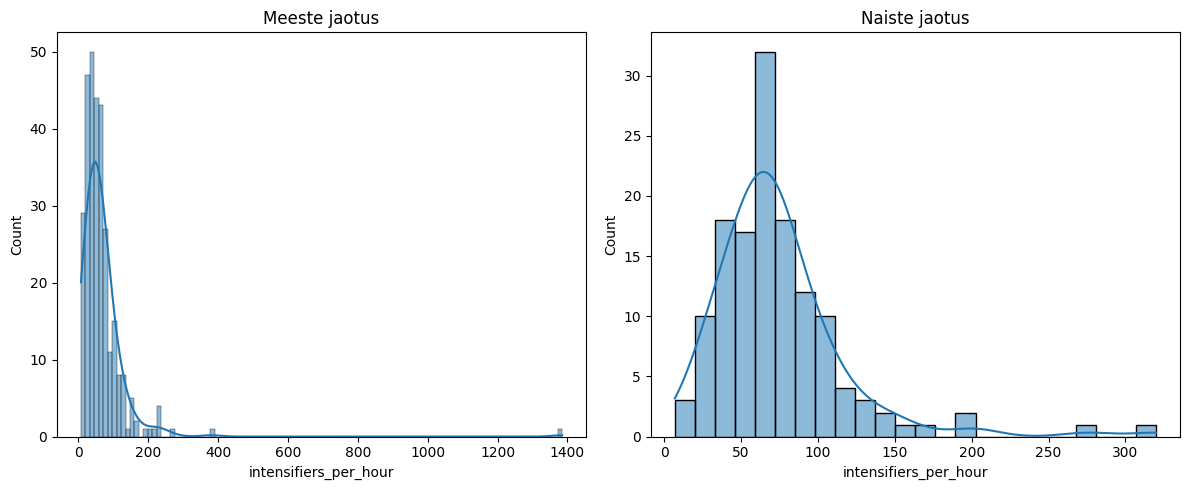

Shapiro (M): W=0.361, p=4.533e-31
Shapiro (F): W=0.798, p=2.356e-12
Mann–Whitney U: U=15426.500, p=7.011e-05


In [5]:

df = pd.read_csv("data/intensiivistajad_per_section.csv")  
print(df.head())
# Vali eraldi meeste ja naiste andmed
men   = df[df["gender"] == "M"]["intensifiers_per_hour"]
women = df[df["gender"] == "F"]["intensifiers_per_hour"]

# Visualiseerimine

#  Jaotuse histogrammid koos KDE-ga
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)                     
sns.histplot(men, kde=True)              
plt.title("Meeste jaotus")              

plt.subplot(1, 2, 2)                     
sns.histplot(women, kde=True)            
plt.title("Naiste jaotus")               

plt.tight_layout()                       
plt.show()                               

# Normaaljaotuse test (Shapiro–Wilk)
W_m, p_m = shapiro(men)   # meeste W-statistik ja p-väärtus
W_f, p_f = shapiro(women) # naiste W-statistik ja p-väärtus
print(f"Shapiro (M): W={W_m:.3f}, p={p_m:.3e}")
print(f"Shapiro (F): W={W_f:.3f}, p={p_f:.3e}")

# Statistilise testi valik
if p_m > 0.05 and p_f > 0.05:
    # Kui mõlema grupi jaotus on normaalne – kontrollime dispersioonide võrdsust
    stat_lev, p_lev = levene(men, women)
    equal_var = (p_lev > 0.05)   # True, kui dispersioonid on võrdsed
    print(f"Levene: stat={stat_lev:.3f}, p={p_lev:.3f} → equal_var={equal_var}")

    # T-test (Student või Welch)
    t_stat, p_t = ttest_ind(men, women, equal_var=equal_var)
    print(f"t-test (equal_var={equal_var}): t={t_stat:.3f}, p={p_t:.3e}")

    # Mõjusuuruse arvutamine (Cohen’s d)
    import numpy as np
    diff = men.mean() - women.mean()
    pooled_sd = np.sqrt((men.std(ddof=1)**2 + women.std(ddof=1)**2) / 2)
    cohens_d = diff / pooled_sd
    print(f"Cohen’s d = {cohens_d:.3f}")
else:
    # Kui vähemalt ühe grupi jaotus ei ole normaalne – Mann–Whitney U-test
    U, p_u = mannwhitneyu(men, women)
    print(f"Mann–Whitney U: U={U:.3f}, p={p_u:.3e}")


                                          episode_id  section_index gender  \
0  20190101_mehed_ei_nuta_suur_uusaastasaade_abso...              1      M   
1  20190101_mehed_ei_nuta_suur_uusaastasaade_abso...              2      M   
2  20190101_mehed_ei_nuta_suur_uusaastasaade_abso...              3      M   
3  20190101_mehed_ei_nuta_suur_uusaastasaade_abso...              4      M   
4  20190101_mehed_ei_nuta_suur_uusaastasaade_abso...              5      M   

   total_pronoomenid    minutes  pronoomenid_per_hour  
0                 33   6.895333                287.15  
1                176  38.380167                275.14  
2                  8   1.458667                329.07  
3                433  70.770667                367.10  
4                  8   0.919333                522.12  


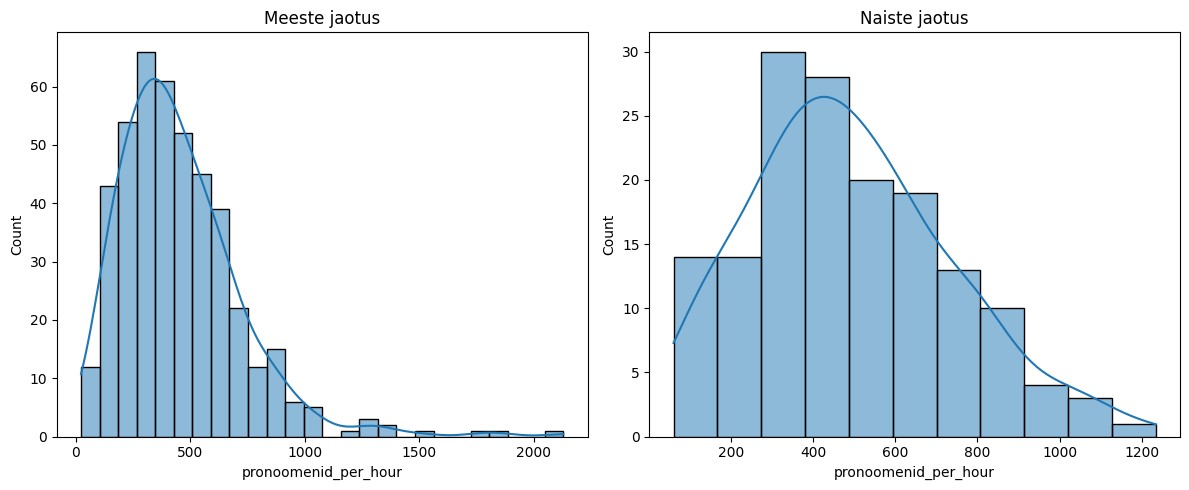

Shapiro (M): W=0.887, p=1.613e-17
Shapiro (F): W=0.976, p=7.243e-03
Mann–Whitney U: U=30417.000, p=2.870e-02


In [6]:

df = pd.read_csv("data/esimese_ja_teise_isik_per_section.csv")  
print(df.head())
# Vali eraldi meeste ja naiste andmed
men   = df[df["gender"] == "M"]["pronoomenid_per_hour"]
women = df[df["gender"] == "F"]["pronoomenid_per_hour"]

# Visualiseerimine

#  Jaotuse histogrammid koos KDE-ga
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)                     
sns.histplot(men, kde=True)              
plt.title("Meeste jaotus")              

plt.subplot(1, 2, 2)                     
sns.histplot(women, kde=True)            
plt.title("Naiste jaotus")               

plt.tight_layout()                       
plt.show()                               

# Normaaljaotuse test (Shapiro–Wilk)
W_m, p_m = shapiro(men)   # meeste W-statistik ja p-väärtus
W_f, p_f = shapiro(women) # naiste W-statistik ja p-väärtus
print(f"Shapiro (M): W={W_m:.3f}, p={p_m:.3e}")
print(f"Shapiro (F): W={W_f:.3f}, p={p_f:.3e}")

# Statistilise testi valik
if p_m > 0.05 and p_f > 0.05:
    # Kui mõlema grupi jaotus on normaalne – kontrollime dispersioonide võrdsust
    stat_lev, p_lev = levene(men, women)
    equal_var = (p_lev > 0.05)   # True, kui dispersioonid on võrdsed
    print(f"Levene: stat={stat_lev:.3f}, p={p_lev:.3f} → equal_var={equal_var}")

    # T-test (Student või Welch)
    t_stat, p_t = ttest_ind(men, women, equal_var=equal_var)
    print(f"t-test (equal_var={equal_var}): t={t_stat:.3f}, p={p_t:.3e}")

    # Mõjusuuruse arvutamine (Cohen’s d)
    import numpy as np
    diff = men.mean() - women.mean()
    pooled_sd = np.sqrt((men.std(ddof=1)**2 + women.std(ddof=1)**2) / 2)
    cohens_d = diff / pooled_sd
    print(f"Cohen’s d = {cohens_d:.3f}")
else:
    # Kui vähemalt ühe grupi jaotus ei ole normaalne – Mann–Whitney U-test
    U, p_u = mannwhitneyu(men, women)
    print(f"Mann–Whitney U: U={U:.3f}, p={p_u:.3e}")
